In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from torch import nn
import torch.nn.functional as F


In [2]:
import torchsummary

In [3]:
BS = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_data = datasets.MNIST(root='mnist/', download=True, transform=
                            transforms.Compose([transforms.ToTensor()]),
                            train=True,)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BS)

In [5]:
class Reshape(nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.view(self.shape)

In [6]:
discriminator = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, stride=1), # 1x28x28 --> 5x24x24
    nn.MaxPool2d(2), # --> 5x12x12
    nn.ReLU(),
    nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1), # --> 10x10x10
    nn.MaxPool2d(2), # --> 10x5x5
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(250, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 1),
    nn.Sigmoid(),
)

discriminator.cuda()

torchsummary.summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 24, 24]             130
         MaxPool2d-2            [-1, 5, 12, 12]               0
              ReLU-3            [-1, 5, 12, 12]               0
            Conv2d-4           [-1, 10, 10, 10]             460
         MaxPool2d-5             [-1, 10, 5, 5]               0
              ReLU-6             [-1, 10, 5, 5]               0
           Flatten-7                  [-1, 250]               0
            Linear-8                  [-1, 100]          25,100
       BatchNorm1d-9                  [-1, 100]             200
             ReLU-10                  [-1, 100]               0
           Linear-11                    [-1, 1]             101
          Sigmoid-12                    [-1, 1]               0
Total params: 25,991
Trainable params: 25,991
Non-trainable params: 0
---------------------------------

In [7]:
generator = nn.Sequential(
    nn.ConvTranspose2d(100, 1024, 4, 2),
    nn.BatchNorm2d(1024),
    nn.ReLU(),
    nn.ConvTranspose2d(1024, 512, 4, 2),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.ConvTranspose2d(512, 256, 4, 2),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.ConvTranspose2d(256, 64, 4, 1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.ConvTranspose2d(64, 1, 4, 1),
    nn.Sigmoid(),
)

generator.cuda()


torchsummary.summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 1024, 4, 4]       1,639,424
       BatchNorm2d-2           [-1, 1024, 4, 4]           2,048
              ReLU-3           [-1, 1024, 4, 4]               0
   ConvTranspose2d-4          [-1, 512, 10, 10]       8,389,120
       BatchNorm2d-5          [-1, 512, 10, 10]           1,024
              ReLU-6          [-1, 512, 10, 10]               0
   ConvTranspose2d-7          [-1, 256, 22, 22]       2,097,408
       BatchNorm2d-8          [-1, 256, 22, 22]             512
              ReLU-9          [-1, 256, 22, 22]               0
  ConvTranspose2d-10           [-1, 64, 25, 25]         262,208
      BatchNorm2d-11           [-1, 64, 25, 25]             128
             ReLU-12           [-1, 64, 25, 25]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]           1,025
          Sigmoid-14            [-1, 1,

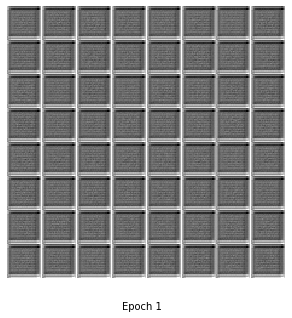

In [8]:
fixed_noise = torch.randn(64, 100, 1, 1)
image_size = 28

import os
def plot_result(generator, noise, num_epoch, save=False, 
                save_dir='my_MNIST_DCGAN_results/', show=False, fig_size=(5, 5)):
    generator.eval()
    image_size = 28
    noise = noise.cuda()
    gen_image = generator(noise)
#     gen_image = denorm(gen_image)

    generator.train()
    plot_gen_image(gen_image, num_epoch, save, save_dir, show, fig_size)

def plot_gen_image(gen_image, num_epoch, save=False, 
                save_dir='my_MNIST_DCGAN_results/', show=False, fig_size=(5, 5)):
    n_rows = np.sqrt(gen_image.size()[0]).astype(np.int32)
    n_cols = np.sqrt(gen_image.size()[0]).astype(np.int32)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size)
    for ax, img in zip(axes.flatten(), gen_image):
        ax.axis('off')
        ax.set_adjustable('box')
        ax.imshow(img.cpu().data.view(image_size, image_size).numpy(), cmap='gray_r', aspect='equal')
    plt.subplots_adjust(wspace=0, hspace=0)
    title = 'Epoch {0}'.format(num_epoch+1)
    fig.text(0.5, 0.04, title, ha='center')

    # save figure
    if save:
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        save_fn = save_dir + 'MNIST_DCGAN_epoch_{:d}'.format(num_epoch+1) + '.png'
        plt.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()
        
plot_result(generator, fixed_noise, 0, show=True)

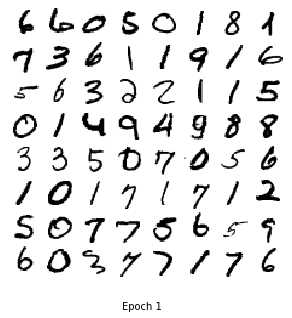

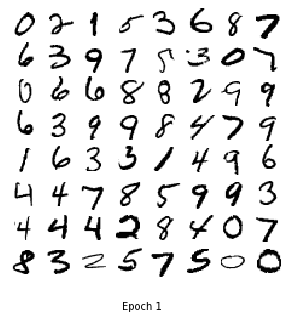

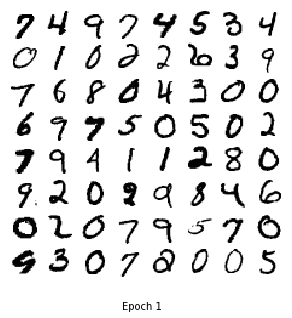

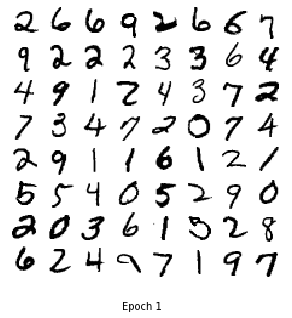

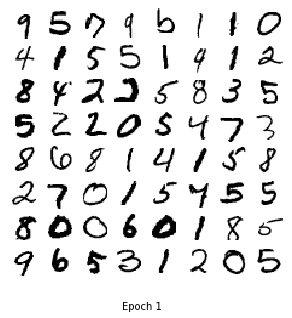

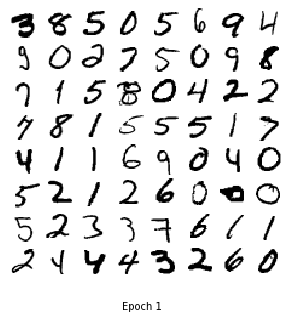

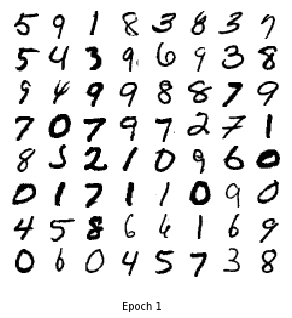

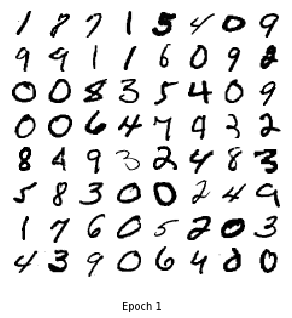

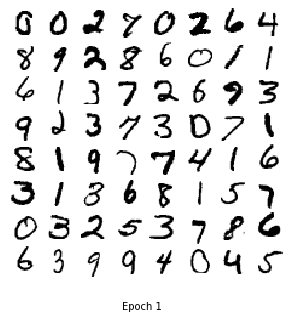

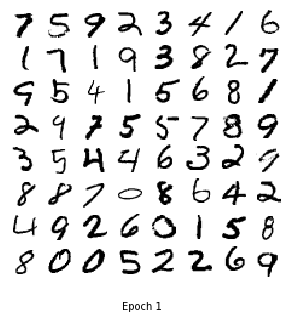

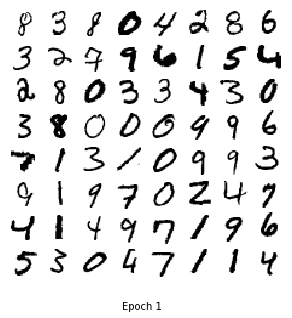

In [9]:
for _id,( _d, _ )in enumerate(train_loader):
    len(_d), plot_gen_image(_d, 0, show=True, save=False)
    if _id == 10:
        break

In [10]:
lr = 1e-4

optim_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optim_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
loss_fn = nn.BCELoss()

In [12]:
D_avg_losses = []
G_avg_losses = []

In [13]:
import time

Epoch:  1
     D loss: 1.4091780185699463 G loss: 0.6290239095687866
     D loss: 1.3938591480255127 G loss: 0.5976834297180176
     D loss: 1.3805207014083862 G loss: 0.6294811367988586
     D loss: 1.3681057691574097 G loss: 0.6572185158729553
     D loss: 1.3506048917770386 G loss: 0.6858513355255127
     D loss: 1.330317735671997 G loss: 0.7117283940315247
     D loss: 1.308763027191162 G loss: 0.7233295440673828
     D loss: 1.308176040649414 G loss: 0.730155348777771
     D loss: 1.2872809171676636 G loss: 0.7399685382843018
     D loss: 1.2752388715744019 G loss: 0.7588033676147461
Epoch: 1 Loss: G: 0.686750054359436 D: 1.3467092514038086 Time: 75 Avg Time: 75.26125359535217


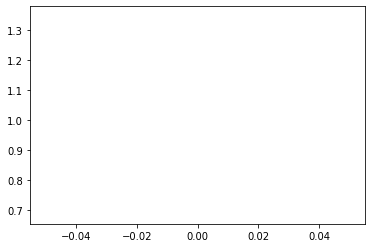

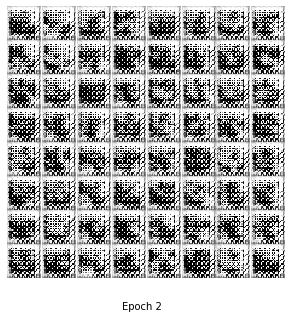

Epoch:  2
     D loss: 1.2791260480880737 G loss: 0.7734333872795105
     D loss: 1.2491722106933594 G loss: 0.7894395589828491
     D loss: 1.2352616786956787 G loss: 0.7892100811004639
     D loss: 1.2223773002624512 G loss: 0.8023834228515625
     D loss: 1.230377197265625 G loss: 0.8112608194351196
     D loss: 1.181915283203125 G loss: 0.8266562223434448
     D loss: 1.179819941520691 G loss: 0.8279260396957397
     D loss: 1.1964354515075684 G loss: 0.8222179412841797
     D loss: 1.193981647491455 G loss: 0.8272917866706848
     D loss: 1.1968135833740234 G loss: 0.7896415591239929
Epoch: 2 Loss: G: 0.8051185011863708 D: 1.2181024551391602 Time: 76 Avg Time: 75.47105312347412


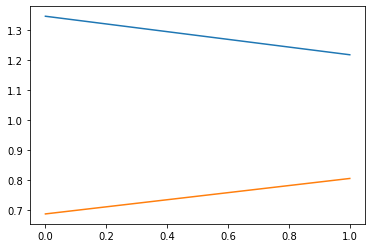

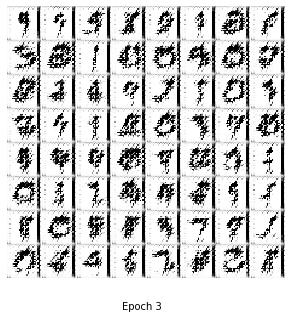

Epoch:  3
     D loss: 1.2491868734359741 G loss: 0.8284621834754944
     D loss: 1.2481176853179932 G loss: 0.8256027698516846
     D loss: 1.24432373046875 G loss: 0.80843186378479
     D loss: 1.2839263677597046 G loss: 0.8184715509414673
     D loss: 1.31878662109375 G loss: 0.7476292848587036
     D loss: 1.3463079929351807 G loss: 0.7900331616401672
     D loss: 1.2940900325775146 G loss: 0.7787410020828247
     D loss: 1.3498529195785522 G loss: 0.7277265787124634
     D loss: 1.340043544769287 G loss: 0.7489414215087891
     D loss: 1.323028564453125 G loss: 0.7549331188201904
Epoch: 3 Loss: G: 0.7787224054336548 D: 1.2819485664367676 Time: 76 Avg Time: 75.55740149815877


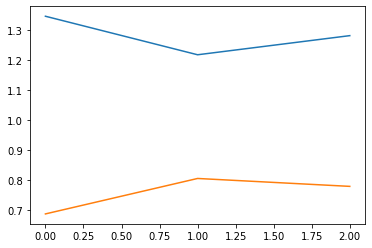

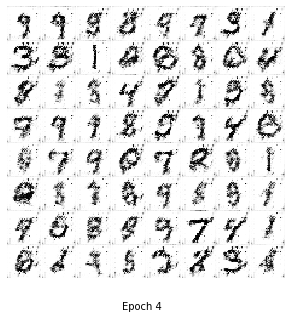

Epoch:  4
     D loss: 1.3045061826705933 G loss: 0.7752436399459839
     D loss: 1.3190174102783203 G loss: 0.7746978998184204
     D loss: 1.3421900272369385 G loss: 0.7344421148300171
     D loss: 1.334935188293457 G loss: 0.7362146377563477
     D loss: 1.3190701007843018 G loss: 0.7485661506652832
     D loss: 1.3737590312957764 G loss: 0.7203502655029297
     D loss: 1.3601963520050049 G loss: 0.7167922258377075
     D loss: 1.3524776697158813 G loss: 0.7639890909194946
     D loss: 1.3555822372436523 G loss: 0.7382665872573853
     D loss: 1.3507364988327026 G loss: 0.729337215423584
Epoch: 4 Loss: G: 0.7361050248146057 D: 1.3486344814300537 Time: 76 Avg Time: 75.6628577709198


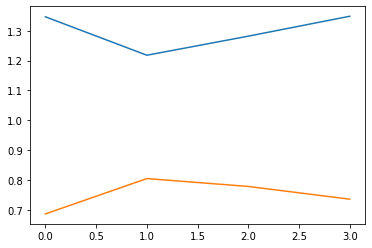

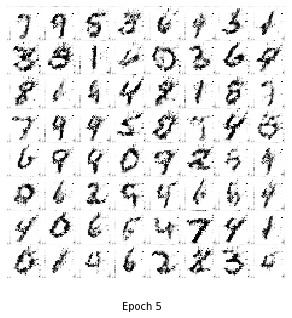

Epoch:  5
     D loss: 1.3562911748886108 G loss: 0.7288179397583008
     D loss: 1.3485362529754639 G loss: 0.7372127771377563
     D loss: 1.342031717300415 G loss: 0.7364388108253479
     D loss: 1.3438291549682617 G loss: 0.7519734501838684
     D loss: 1.365760326385498 G loss: 0.7263656854629517
     D loss: 1.405811071395874 G loss: 0.7253298759460449
     D loss: 1.348374366760254 G loss: 0.7231976985931396
     D loss: 1.3797358274459839 G loss: 0.7064847946166992
     D loss: 1.3251923322677612 G loss: 0.7401817440986633
     D loss: 1.3790299892425537 G loss: 0.7141667604446411
Epoch: 5 Loss: G: 0.7212466597557068 D: 1.3700898885726929 Time: 76 Avg Time: 75.75983099937439


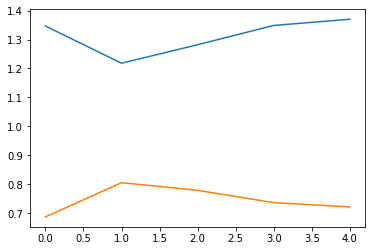

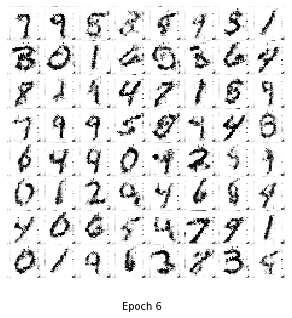

Epoch:  6
     D loss: 1.3703501224517822 G loss: 0.72514808177948
     D loss: 1.4041357040405273 G loss: 0.6910876631736755
     D loss: 1.3985660076141357 G loss: 0.7071648240089417
     D loss: 1.3943150043487549 G loss: 0.7026961445808411
     D loss: 1.4006953239440918 G loss: 0.6939586400985718
     D loss: 1.3428725004196167 G loss: 0.7371091842651367
     D loss: 1.3680692911148071 G loss: 0.6844553351402283
     D loss: 1.3829429149627686 G loss: 0.7022942900657654
     D loss: 1.367179274559021 G loss: 0.7410275340080261
     D loss: 1.3461381196975708 G loss: 0.7417570352554321
Epoch: 6 Loss: G: 0.7177311182022095 D: 1.3738306760787964 Time: 76 Avg Time: 75.85948487122853


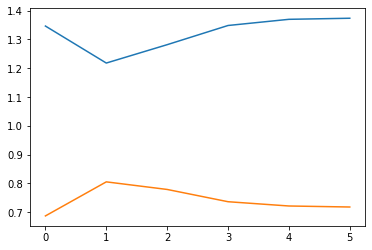

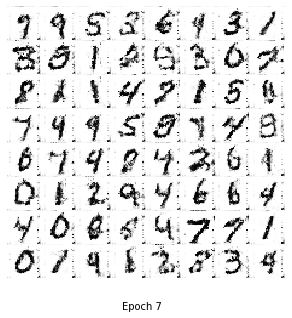

Epoch:  7
     D loss: 1.3445165157318115 G loss: 0.7301194667816162
     D loss: 1.3921314477920532 G loss: 0.713613748550415
     D loss: 1.351020336151123 G loss: 0.7410703897476196
     D loss: 1.3791441917419434 G loss: 0.6887465119361877
     D loss: 1.399832010269165 G loss: 0.7029060125350952
     D loss: 1.4034969806671143 G loss: 0.7053769826889038
     D loss: 1.3656249046325684 G loss: 0.7093541622161865
     D loss: 1.3572595119476318 G loss: 0.715402364730835
     D loss: 1.3929369449615479 G loss: 0.7056057453155518
     D loss: 1.4020506143569946 G loss: 0.7203643321990967
Epoch: 7 Loss: G: 0.7157183885574341 D: 1.3759421110153198 Time: 76 Avg Time: 75.93431537491935


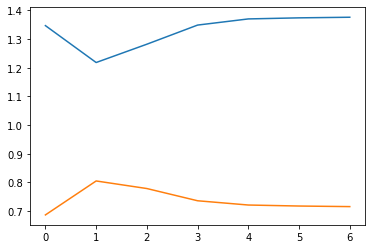

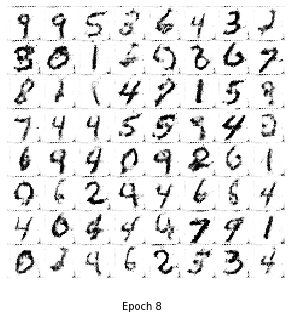

Epoch:  8
     D loss: 1.3658478260040283 G loss: 0.7159232497215271
     D loss: 1.3486887216567993 G loss: 0.7320966720581055
     D loss: 1.420292854309082 G loss: 0.6913732290267944
     D loss: 1.3778724670410156 G loss: 0.7007758021354675
     D loss: 1.3749232292175293 G loss: 0.7017790079116821
     D loss: 1.3742470741271973 G loss: 0.7069455981254578
     D loss: 1.363388180732727 G loss: 0.7125157117843628
     D loss: 1.3624589443206787 G loss: 0.7215442657470703
     D loss: 1.3926358222961426 G loss: 0.6942019462585449
     D loss: 1.408599853515625 G loss: 0.6960555911064148
Epoch: 8 Loss: G: 0.7126625776290894 D: 1.379440426826477 Time: 76 Avg Time: 75.97936341166496


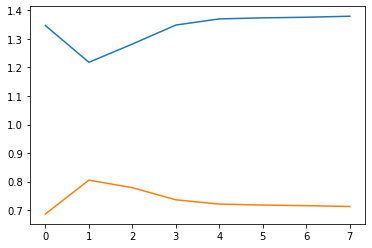

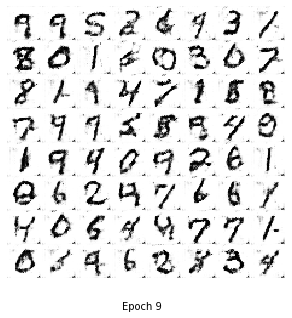

Epoch:  9
     D loss: 1.3412188291549683 G loss: 0.7381606101989746
     D loss: 1.3805618286132812 G loss: 0.7144728899002075
     D loss: 1.4103931188583374 G loss: 0.6789937019348145
     D loss: 1.3723889589309692 G loss: 0.7056007981300354
     D loss: 1.3846304416656494 G loss: 0.7075859308242798
     D loss: 1.3758151531219482 G loss: 0.71629798412323
     D loss: 1.363227128982544 G loss: 0.7194802761077881
     D loss: 1.4006744623184204 G loss: 0.7046182155609131
     D loss: 1.3955533504486084 G loss: 0.7113117575645447
     D loss: 1.3573369979858398 G loss: 0.720689058303833
Epoch: 9 Loss: G: 0.7088251709938049 D: 1.3825774192810059 Time: 76 Avg Time: 76.01883893542819


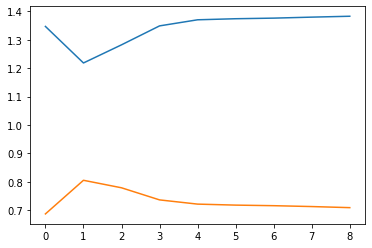

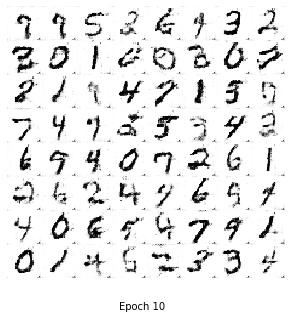

Epoch:  10
     D loss: 1.3785574436187744 G loss: 0.7080256938934326
     D loss: 1.3675668239593506 G loss: 0.7077006697654724
     D loss: 1.3915016651153564 G loss: 0.702160120010376
     D loss: 1.4097530841827393 G loss: 0.6873511075973511
     D loss: 1.3885242938995361 G loss: 0.7197842001914978
     D loss: 1.3888474702835083 G loss: 0.7043412923812866
     D loss: 1.3731443881988525 G loss: 0.7007073163986206
     D loss: 1.4112441539764404 G loss: 0.6999074220657349
     D loss: 1.3620576858520508 G loss: 0.7206041812896729
     D loss: 1.3797719478607178 G loss: 0.7218043208122253
Epoch: 10 Loss: G: 0.7089055776596069 D: 1.3821766376495361 Time: 76 Avg Time: 76.04819695949554


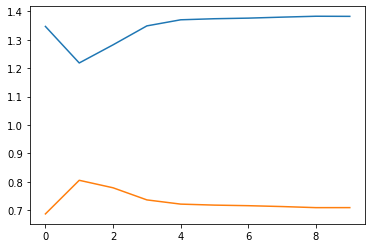

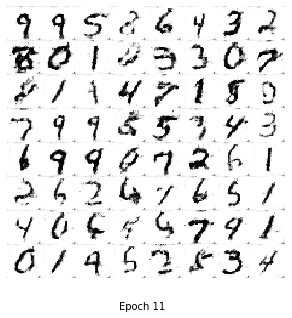

Epoch:  11
     D loss: 1.4177902936935425 G loss: 0.6858252286911011
     D loss: 1.4085079431533813 G loss: 0.7075878977775574
     D loss: 1.3644665479660034 G loss: 0.723118007183075
     D loss: 1.3861894607543945 G loss: 0.682256281375885
     D loss: 1.3789958953857422 G loss: 0.703895092010498
     D loss: 1.376043438911438 G loss: 0.7078462839126587
     D loss: 1.3785150051116943 G loss: 0.7112330198287964
     D loss: 1.3869237899780273 G loss: 0.7217525243759155
     D loss: 1.3832099437713623 G loss: 0.7024849653244019
     D loss: 1.3714154958724976 G loss: 0.711566686630249
Epoch: 11 Loss: G: 0.7077613472938538 D: 1.382200837135315 Time: 76 Avg Time: 76.0785191709345


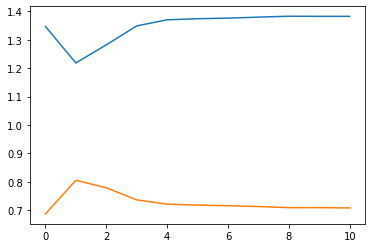

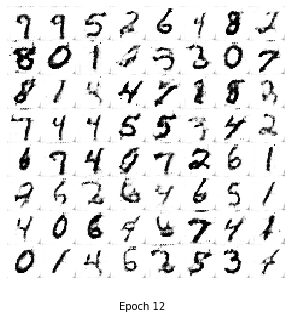

Epoch:  12
     D loss: 1.3829180002212524 G loss: 0.7192578315734863
     D loss: 1.3635313510894775 G loss: 0.7102131843566895
     D loss: 1.3907040357589722 G loss: 0.6947343349456787
     D loss: 1.3943328857421875 G loss: 0.7067964673042297
     D loss: 1.3888881206512451 G loss: 0.7003756761550903
     D loss: 1.3821666240692139 G loss: 0.7024553418159485
     D loss: 1.3788259029388428 G loss: 0.6993657946586609
     D loss: 1.4029054641723633 G loss: 0.6830658912658691
     D loss: 1.3766483068466187 G loss: 0.7124148607254028
     D loss: 1.3879408836364746 G loss: 0.7011646032333374
Epoch: 12 Loss: G: 0.7059646248817444 D: 1.3830013275146484 Time: 76 Avg Time: 76.09962304433186


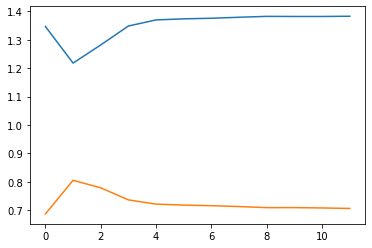

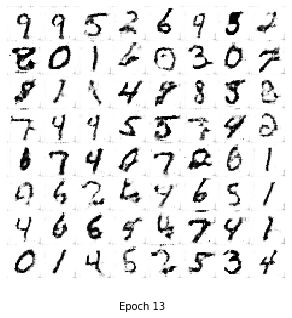

Epoch:  13
     D loss: 1.3927220106124878 G loss: 0.704194188117981
     D loss: 1.369080901145935 G loss: 0.7215875387191772
     D loss: 1.392315149307251 G loss: 0.708564281463623
     D loss: 1.4159387350082397 G loss: 0.6907272338867188
     D loss: 1.3931314945220947 G loss: 0.7090117931365967
     D loss: 1.3829864263534546 G loss: 0.7143022418022156
     D loss: 1.4039440155029297 G loss: 0.6974795460700989
     D loss: 1.3850129842758179 G loss: 0.7228610515594482
     D loss: 1.4033634662628174 G loss: 0.7053874731063843
     D loss: 1.3744926452636719 G loss: 0.7087584733963013
Epoch: 13 Loss: G: 0.706031322479248 D: 1.3827183246612549 Time: 76 Avg Time: 76.12293657889732


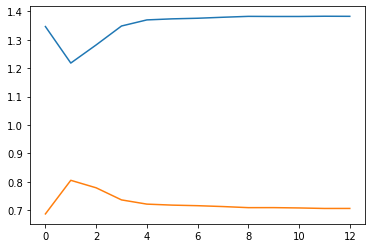

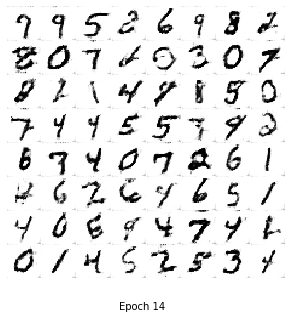

Epoch:  14
     D loss: 1.419825553894043 G loss: 0.6890153884887695
     D loss: 1.3844470977783203 G loss: 0.704824686050415
     D loss: 1.3552274703979492 G loss: 0.7390204668045044
     D loss: 1.370159387588501 G loss: 0.7061164975166321
     D loss: 1.3803155422210693 G loss: 0.7061432600021362
     D loss: 1.3799052238464355 G loss: 0.7172070741653442
     D loss: 1.370550513267517 G loss: 0.7169589400291443
     D loss: 1.399591088294983 G loss: 0.6987640857696533
     D loss: 1.3743748664855957 G loss: 0.70798659324646
     D loss: 1.3934800624847412 G loss: 0.6876977682113647
Epoch: 14 Loss: G: 0.7053003907203674 D: 1.3829965591430664 Time: 76 Avg Time: 76.14339785916465


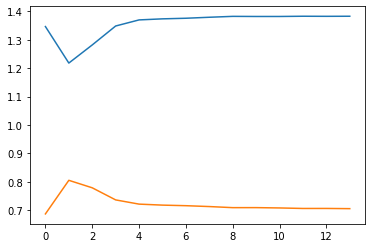

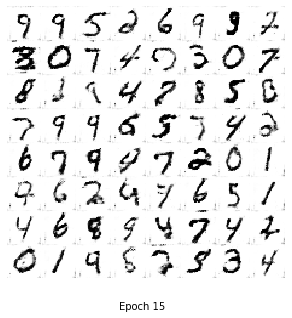

Epoch:  15
     D loss: 1.3692378997802734 G loss: 0.7097271680831909
     D loss: 1.3805639743804932 G loss: 0.6919639110565186
     D loss: 1.3905408382415771 G loss: 0.7093784809112549
     D loss: 1.3625249862670898 G loss: 0.7153935432434082
     D loss: 1.3728482723236084 G loss: 0.7060108184814453
     D loss: 1.3681373596191406 G loss: 0.7133405804634094
     D loss: 1.3817050457000732 G loss: 0.7136074304580688
     D loss: 1.3812261819839478 G loss: 0.7199731469154358
     D loss: 1.3884775638580322 G loss: 0.7100116610527039
     D loss: 1.3848168849945068 G loss: 0.6944626569747925
Epoch: 15 Loss: G: 0.7044804096221924 D: 1.3826593160629272 Time: 76 Avg Time: 76.15982616742453


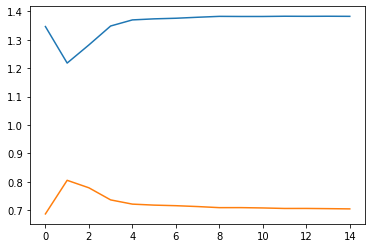

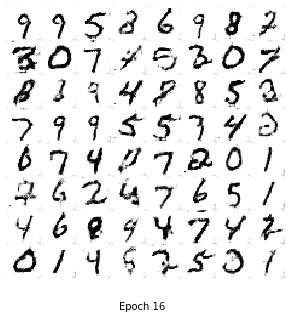

Epoch:  16
     D loss: 1.3981181383132935 G loss: 0.6930060386657715
     D loss: 1.3871110677719116 G loss: 0.7129284143447876
     D loss: 1.3898165225982666 G loss: 0.7093889713287354
     D loss: 1.388779878616333 G loss: 0.693516731262207
     D loss: 1.3828628063201904 G loss: 0.7074081301689148
     D loss: 1.3673560619354248 G loss: 0.718998908996582
     D loss: 1.3986376523971558 G loss: 0.6909317970275879
     D loss: 1.3682621717453003 G loss: 0.719963550567627
     D loss: 1.3853602409362793 G loss: 0.7036254405975342
     D loss: 1.4006166458129883 G loss: 0.6907423734664917
Epoch: 16 Loss: G: 0.7036018967628479 D: 1.383345365524292 Time: 76 Avg Time: 76.1746017485857


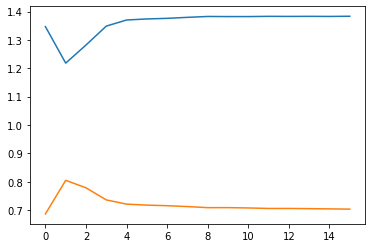

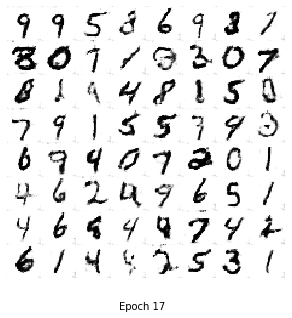

Epoch:  17
     D loss: 1.3689703941345215 G loss: 0.7141916751861572
     D loss: 1.3806214332580566 G loss: 0.6965522766113281
     D loss: 1.3746731281280518 G loss: 0.7039002180099487
     D loss: 1.3931940793991089 G loss: 0.7025271654129028
     D loss: 1.3780796527862549 G loss: 0.7038758993148804
     D loss: 1.3797054290771484 G loss: 0.7016420364379883
     D loss: 1.3733577728271484 G loss: 0.710688591003418
     D loss: 1.3783540725708008 G loss: 0.7003056406974792
     D loss: 1.3883216381072998 G loss: 0.6978045701980591
     D loss: 1.370363712310791 G loss: 0.7139827013015747
Epoch: 17 Loss: G: 0.7035340070724487 D: 1.3832995891571045 Time: 77 Avg Time: 76.19780091678395


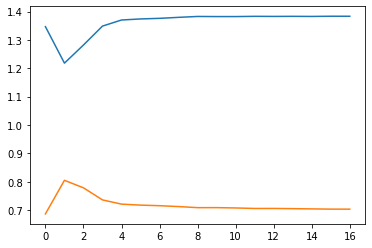

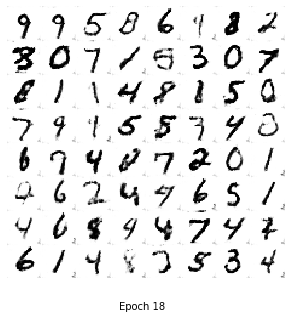

Epoch:  18
     D loss: 1.3882999420166016 G loss: 0.6881822347640991
     D loss: 1.3885772228240967 G loss: 0.7033851146697998
     D loss: 1.3837659358978271 G loss: 0.6985224485397339
     D loss: 1.3950071334838867 G loss: 0.69279944896698
     D loss: 1.3805859088897705 G loss: 0.6942779421806335
     D loss: 1.3639999628067017 G loss: 0.7213606834411621
     D loss: 1.370292067527771 G loss: 0.7136105298995972
     D loss: 1.3960075378417969 G loss: 0.705106258392334
     D loss: 1.3925822973251343 G loss: 0.6864526271820068
     D loss: 1.3719481229782104 G loss: 0.7151287794113159
Epoch: 18 Loss: G: 0.7027938365936279 D: 1.3825533390045166 Time: 76 Avg Time: 76.21073622173733


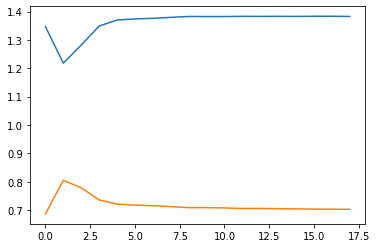

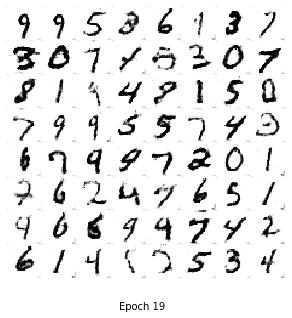

Epoch:  19
     D loss: 1.3753893375396729 G loss: 0.7139413356781006
     D loss: 1.3745238780975342 G loss: 0.7145259380340576
     D loss: 1.3676869869232178 G loss: 0.7137420177459717
     D loss: 1.4000260829925537 G loss: 0.6949874758720398
     D loss: 1.3764359951019287 G loss: 0.6984298825263977
     D loss: 1.3674278259277344 G loss: 0.7133970260620117
     D loss: 1.3651530742645264 G loss: 0.7207962274551392
     D loss: 1.3767166137695312 G loss: 0.7152106761932373
     D loss: 1.3722617626190186 G loss: 0.7116245627403259
     D loss: 1.386782169342041 G loss: 0.6954220533370972
Epoch: 19 Loss: G: 0.7028817534446716 D: 1.3836064338684082 Time: 77 Avg Time: 76.2273193284085


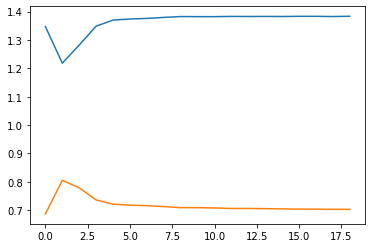

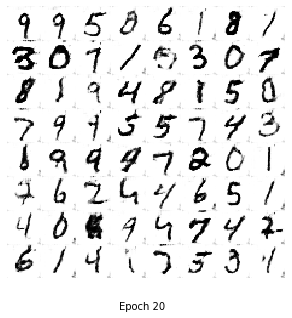

Epoch:  20
     D loss: 1.3931080102920532 G loss: 0.7062605023384094
     D loss: 1.3954176902770996 G loss: 0.7067652344703674
     D loss: 1.4078351259231567 G loss: 0.6913143396377563
     D loss: 1.3881189823150635 G loss: 0.7036278247833252
     D loss: 1.385368824005127 G loss: 0.6999717950820923
     D loss: 1.3899486064910889 G loss: 0.6899245381355286
     D loss: 1.3813787698745728 G loss: 0.7062826156616211
     D loss: 1.3808648586273193 G loss: 0.7048375606536865
     D loss: 1.3791184425354004 G loss: 0.6963768005371094
     D loss: 1.3775159120559692 G loss: 0.6981102228164673
Epoch: 20 Loss: G: 0.702569305896759 D: 1.3832367658615112 Time: 77 Avg Time: 76.24227730035781


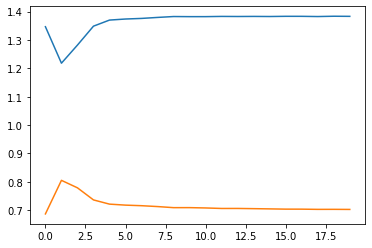

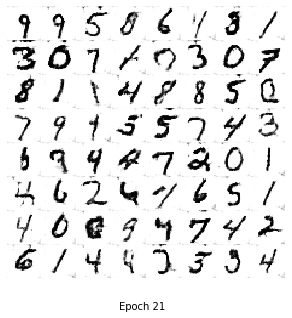

Epoch:  21
     D loss: 1.3946278095245361 G loss: 0.6925254464149475
     D loss: 1.3729830980300903 G loss: 0.7059328556060791
     D loss: 1.3874316215515137 G loss: 0.7028608322143555
     D loss: 1.3799073696136475 G loss: 0.7061585783958435
     D loss: 1.3984041213989258 G loss: 0.6937717199325562
     D loss: 1.397799015045166 G loss: 0.6878977417945862
     D loss: 1.4193873405456543 G loss: 0.6748195290565491
     D loss: 1.383831262588501 G loss: 0.7007104754447937
     D loss: 1.373563528060913 G loss: 0.7064570188522339
     D loss: 1.3717374801635742 G loss: 0.7076618671417236
Epoch: 21 Loss: G: 0.7019544839859009 D: 1.383853793144226 Time: 77 Avg Time: 76.25591548283894


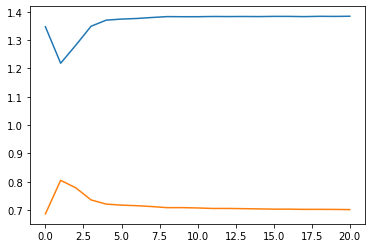

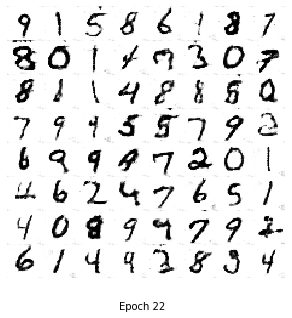

Epoch:  22
     D loss: 1.3871841430664062 G loss: 0.7026095390319824
     D loss: 1.3884623050689697 G loss: 0.6971896886825562
     D loss: 1.375661849975586 G loss: 0.7084771990776062
     D loss: 1.373227834701538 G loss: 0.7105557918548584
     D loss: 1.3701804876327515 G loss: 0.7073562145233154
     D loss: 1.3871617317199707 G loss: 0.7146952152252197
     D loss: 1.3926103115081787 G loss: 0.7016799449920654
     D loss: 1.3753645420074463 G loss: 0.711637020111084
     D loss: 1.380998134613037 G loss: 0.7027205228805542
     D loss: 1.376949429512024 G loss: 0.6991421580314636
Epoch: 22 Loss: G: 0.7016819715499878 D: 1.3838273286819458 Time: 76 Avg Time: 76.26570688594471


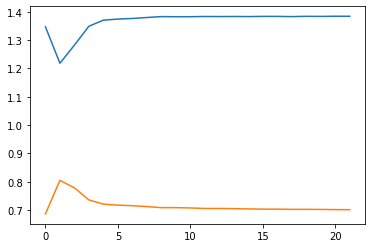

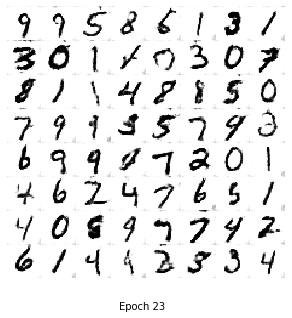

Epoch:  23
     D loss: 1.3938506841659546 G loss: 0.6966552734375
     D loss: 1.38211190700531 G loss: 0.7059956789016724
     D loss: 1.395021677017212 G loss: 0.6889930963516235
     D loss: 1.4045588970184326 G loss: 0.6843653917312622
     D loss: 1.3898842334747314 G loss: 0.6930391788482666
     D loss: 1.3744516372680664 G loss: 0.7012603878974915
     D loss: 1.384678602218628 G loss: 0.702639102935791
     D loss: 1.3774940967559814 G loss: 0.7010215520858765
     D loss: 1.3742315769195557 G loss: 0.7045236825942993
     D loss: 1.3996217250823975 G loss: 0.6954096555709839
Epoch: 23 Loss: G: 0.7009730935096741 D: 1.3838785886764526 Time: 76 Avg Time: 76.27532741297846


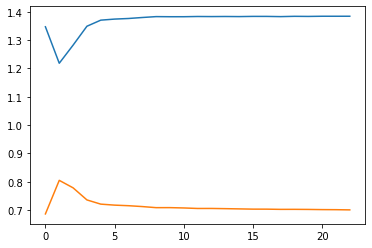

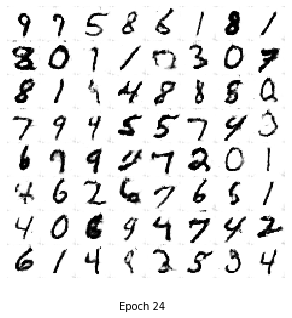

Epoch:  24
     D loss: 1.3699054718017578 G loss: 0.7051888704299927
     D loss: 1.3765813112258911 G loss: 0.6947602033615112
     D loss: 1.3766930103302002 G loss: 0.7043974995613098
     D loss: 1.3973863124847412 G loss: 0.7009145021438599
     D loss: 1.3715391159057617 G loss: 0.7212330102920532
     D loss: 1.3915812969207764 G loss: 0.6951419115066528
     D loss: 1.3698217868804932 G loss: 0.7073560953140259
     D loss: 1.3887696266174316 G loss: 0.7043671011924744
     D loss: 1.392364740371704 G loss: 0.6935967206954956
     D loss: 1.381587266921997 G loss: 0.699083685874939
Epoch: 24 Loss: G: 0.7005096673965454 D: 1.3849676847457886 Time: 77 Avg Time: 76.28594320019086


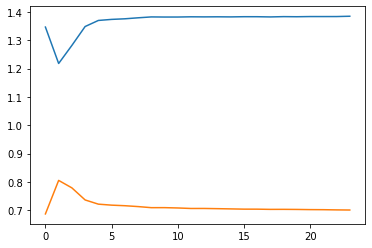

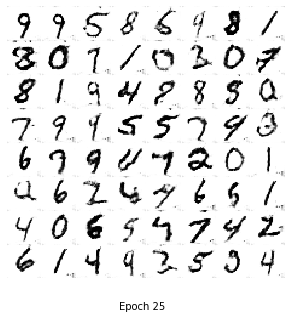

Epoch:  25
     D loss: 1.3818185329437256 G loss: 0.7036118507385254
     D loss: 1.3803892135620117 G loss: 0.7013058662414551
     D loss: 1.3766117095947266 G loss: 0.6958435773849487
     D loss: 1.3967586755752563 G loss: 0.6940076351165771
     D loss: 1.3953895568847656 G loss: 0.690224289894104
     D loss: 1.3834151029586792 G loss: 0.7072910666465759
     D loss: 1.3748139142990112 G loss: 0.701011061668396
     D loss: 1.379399061203003 G loss: 0.7000019550323486
     D loss: 1.3851876258850098 G loss: 0.703540563583374
     D loss: 1.3783187866210938 G loss: 0.7039667367935181
Epoch: 25 Loss: G: 0.7006260752677917 D: 1.3835594654083252 Time: 76 Avg Time: 76.29279539108276


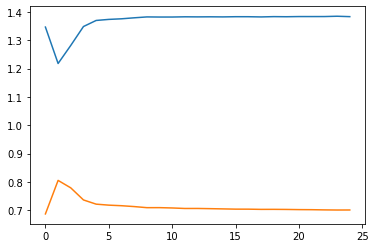

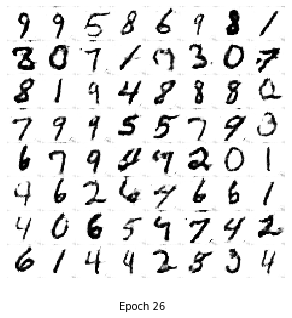

Epoch:  26
     D loss: 1.3769428730010986 G loss: 0.7073663473129272
     D loss: 1.3757984638214111 G loss: 0.7063044905662537
     D loss: 1.3725157976150513 G loss: 0.7092273235321045
     D loss: 1.3974480628967285 G loss: 0.6938605904579163
     D loss: 1.3809113502502441 G loss: 0.7050377726554871
     D loss: 1.3867069482803345 G loss: 0.6958461999893188
     D loss: 1.3749951124191284 G loss: 0.6910158395767212
     D loss: 1.3905870914459229 G loss: 0.6977083683013916
     D loss: 1.394148826599121 G loss: 0.6900804042816162
     D loss: 1.395358920097351 G loss: 0.686578631401062
Epoch: 26 Loss: G: 0.7000422477722168 D: 1.385025143623352 Time: 77 Avg Time: 76.30447900295258


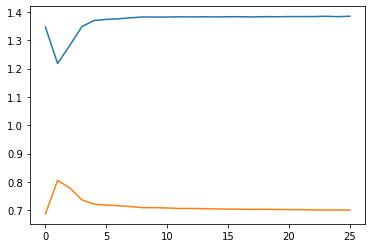

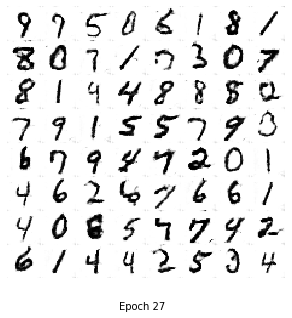

Epoch:  27
     D loss: 1.386673927307129 G loss: 0.6911641955375671
     D loss: 1.3874971866607666 G loss: 0.6955875158309937
     D loss: 1.389709711074829 G loss: 0.6894830465316772
     D loss: 1.3725454807281494 G loss: 0.7114970684051514
     D loss: 1.3927404880523682 G loss: 0.6971310377120972
     D loss: 1.3831526041030884 G loss: 0.7008455991744995
     D loss: 1.3807786703109741 G loss: 0.705895185470581
     D loss: 1.3720868825912476 G loss: 0.7275223135948181
     D loss: 1.3799583911895752 G loss: 0.7022567987442017
     D loss: 1.3700001239776611 G loss: 0.716549277305603
Epoch: 27 Loss: G: 0.6994739770889282 D: 1.3845112323760986 Time: 77 Avg Time: 76.3142813929805


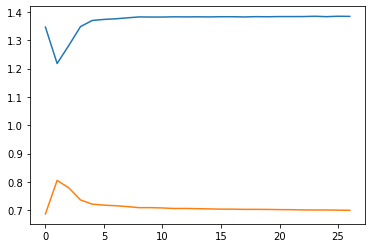

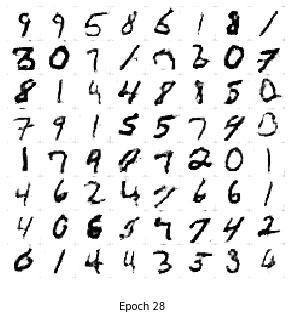

Epoch:  28
     D loss: 1.386015772819519 G loss: 0.7039263844490051
     D loss: 1.3803718090057373 G loss: 0.7056323289871216
     D loss: 1.378350019454956 G loss: 0.6974756121635437
     D loss: 1.3941900730133057 G loss: 0.6957876682281494
     D loss: 1.379530429840088 G loss: 0.6945765614509583
     D loss: 1.384963870048523 G loss: 0.6920062899589539
     D loss: 1.3799817562103271 G loss: 0.6942059993743896
     D loss: 1.3980358839035034 G loss: 0.7043701410293579
     D loss: 1.3892319202423096 G loss: 0.7004686594009399
     D loss: 1.3999574184417725 G loss: 0.688530445098877
Epoch: 28 Loss: G: 0.6994070410728455 D: 1.3847827911376953 Time: 77 Avg Time: 76.33793374470302


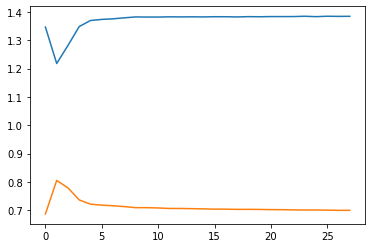

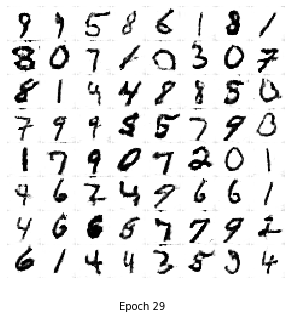

Epoch:  29
     D loss: 1.3845434188842773 G loss: 0.7068920135498047
     D loss: 1.377320408821106 G loss: 0.7007398009300232
     D loss: 1.3846416473388672 G loss: 0.7021753787994385
     D loss: 1.3952858448028564 G loss: 0.6852968335151672
     D loss: 1.3841912746429443 G loss: 0.6979087591171265
     D loss: 1.3927627801895142 G loss: 0.6984483003616333
     D loss: 1.391991138458252 G loss: 0.6898823976516724
     D loss: 1.3856728076934814 G loss: 0.6962602138519287
     D loss: 1.3909903764724731 G loss: 0.6924320459365845
     D loss: 1.399383783340454 G loss: 0.6936207413673401
Epoch: 29 Loss: G: 0.6993808746337891 D: 1.3847250938415527 Time: 77 Avg Time: 76.35726645075042


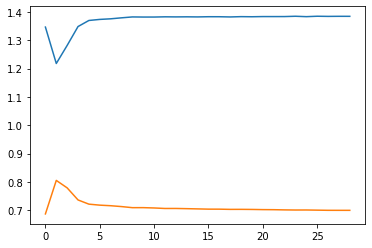

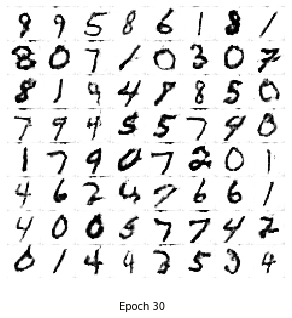

Epoch:  30
     D loss: 1.3934102058410645 G loss: 0.6988973021507263
     D loss: 1.380746603012085 G loss: 0.6989691257476807
     D loss: 1.376751184463501 G loss: 0.7014869451522827
     D loss: 1.3938995599746704 G loss: 0.7011934518814087
     D loss: 1.3733426332473755 G loss: 0.6985886096954346
     D loss: 1.3973232507705688 G loss: 0.6847028732299805
     D loss: 1.3823732137680054 G loss: 0.6938190460205078
     D loss: 1.3861422538757324 G loss: 0.7026220560073853
     D loss: 1.3918263912200928 G loss: 0.6966251134872437
     D loss: 1.3809585571289062 G loss: 0.7070745229721069
Epoch: 30 Loss: G: 0.6993469595909119 D: 1.384284257888794 Time: 77 Avg Time: 76.37307884693146


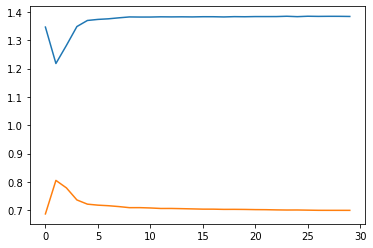

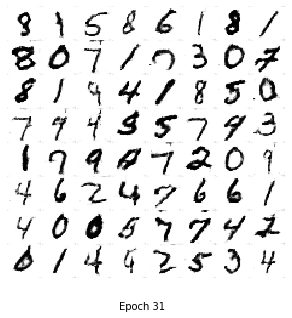

Epoch:  31
     D loss: 1.3907661437988281 G loss: 0.6906750202178955
     D loss: 1.3911523818969727 G loss: 0.7000870704650879
     D loss: 1.3811787366867065 G loss: 0.6994585394859314
     D loss: 1.3854748010635376 G loss: 0.6963039636611938
     D loss: 1.3859193325042725 G loss: 0.6982357501983643
     D loss: 1.3842620849609375 G loss: 0.6935207843780518
     D loss: 1.4018981456756592 G loss: 0.6932727098464966
     D loss: 1.3741388320922852 G loss: 0.7042884826660156
     D loss: 1.3955895900726318 G loss: 0.6964633464813232
     D loss: 1.3868722915649414 G loss: 0.6945185661315918
Epoch: 31 Loss: G: 0.6986152529716492 D: 1.3854089975357056 Time: 77 Avg Time: 76.40095510021332


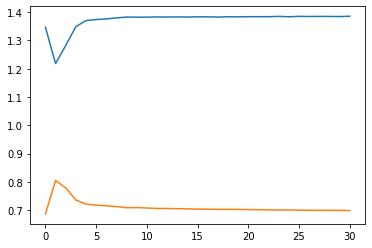

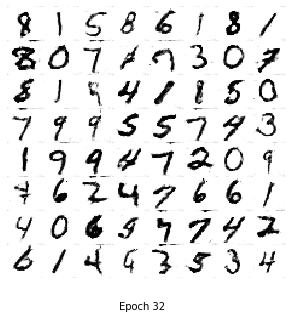

Epoch:  32
     D loss: 1.383676290512085 G loss: 0.6943196058273315
     D loss: 1.3922048807144165 G loss: 0.6993755102157593
     D loss: 1.3836677074432373 G loss: 0.6968708038330078
     D loss: 1.3759764432907104 G loss: 0.6965746879577637
     D loss: 1.3876234292984009 G loss: 0.7028493881225586
     D loss: 1.38932466506958 G loss: 0.7062722444534302
     D loss: 1.3889130353927612 G loss: 0.7043923139572144
     D loss: 1.3906731605529785 G loss: 0.6958523392677307
     D loss: 1.396127700805664 G loss: 0.6918317675590515
     D loss: 1.3856450319290161 G loss: 0.7046690583229065
Epoch: 32 Loss: G: 0.6987306475639343 D: 1.3847477436065674 Time: 78 Avg Time: 76.43607334792614


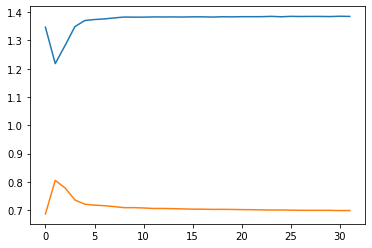

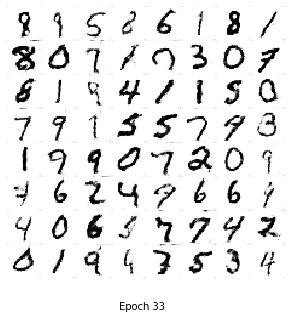

Epoch:  33


In [14]:
EPOCH = 100
all_times = []
for e in range(EPOCH):
    print("Epoch: ", e+1)
    D_losses = []
    G_losses = []
    discriminator.train()
    generator.train()
    t0 = time.time()
    for bid, (real_images, _) in enumerate(train_loader):
        bs = real_images.size()[0]
        real_images = real_images.to(DEVICE)
        real_y = torch.ones(bs).to(DEVICE)
        noise = torch.randn(bs, 100, 1, 1).to(DEVICE)
        fake_images = generator(noise)
        fake_y = torch.zeros_like(real_y).to(DEVICE)
        
        # update Discriminator
        optim_discriminator.zero_grad()
        loss_D = loss_fn(discriminator(real_images).flatten(), real_y)
        loss_D += loss_fn(discriminator(fake_images).flatten(), fake_y)
        loss_D.backward(retain_graph=True)
        optim_discriminator.step()
        
        # update Generator
        optim_generator.zero_grad()
        fake_images = generator(noise)
        real_y = torch.ones(bs).to(DEVICE)
        loss_G = loss_fn(discriminator(fake_images).flatten(), real_y)
        loss_G.backward()
        optim_generator.step()
        
        if (bid+1) % (len(train_loader) // 10) == 0:
            print("    ", "D loss:", loss_D.item(), "G loss:", loss_G.item())
        D_losses.append(loss_D.item())
        G_losses.append(loss_G.item())
    epoch_time = time.time() - t0
    all_times.append(epoch_time)
    D_avg_loss = torch.mean(torch.FloatTensor(D_losses)).item()
    G_avg_loss = torch.mean(torch.FloatTensor(G_losses)).item()
    
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)
    print("Epoch:", e+1, "Loss: G:", G_avg_loss, "D:", D_avg_loss, 
          "Time:", round(epoch_time), "Avg Time:", np.mean(all_times))
    
    plt.plot(range(len(D_avg_losses)), D_avg_losses)
    plt.plot(range(len(G_avg_losses)), G_avg_losses)
    plt.show()
    plot_result(generator, fixed_noise, e+1, show=True, save=True)

In [15]:
classifier = nn.Sequential(
    nn.Conv2d(1, 5, 5, 1), # 1x28x28 --> 5x24x24
    nn.MaxPool2d(2),       # --> 5x12x12
    nn.BatchNorm2d(5),     
    nn.ReLU(),
    nn.Conv2d(5, 10, 3, 1),# --> 10x10x10
    nn.MaxPool2d(2),       # --> 10x5x5
    nn.BatchNorm2d(10),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(250, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.Softmax(dim=1),
)

classifier.cuda()

torchsummary.summary(classifier, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 24, 24]             130
         MaxPool2d-2            [-1, 5, 12, 12]               0
       BatchNorm2d-3            [-1, 5, 12, 12]              10
              ReLU-4            [-1, 5, 12, 12]               0
            Conv2d-5           [-1, 10, 10, 10]             460
         MaxPool2d-6             [-1, 10, 5, 5]               0
       BatchNorm2d-7             [-1, 10, 5, 5]              20
              ReLU-8             [-1, 10, 5, 5]               0
           Flatten-9                  [-1, 250]               0
           Linear-10                  [-1, 100]          25,100
      BatchNorm1d-11                  [-1, 100]             200
             ReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 10]           1,010
          Softmax-14                   

In [20]:
train_loader_big = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=512)


test_data = datasets.MNIST('mnist', train=False, transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=256)


optim_classifier = torch.optim.Adam(classifier.parameters(), lr=1e-3)

loss_c = nn.CrossEntropyLoss()

In [21]:
for data, target in train_loader:
    output = classifier(data.cuda())
    print(output, output.argmax(1), target)
    print(loss_c(output, target.cuda()))
    break

tensor([[1.7708e-01, 9.1411e-02, 7.8653e-02, 4.1407e-02, 9.2965e-02, 7.8973e-02,
         8.9236e-02, 1.9609e-01, 4.7995e-02, 1.0618e-01],
        [2.4370e-01, 7.2331e-02, 8.2738e-02, 1.6804e-02, 5.0164e-02, 4.9462e-02,
         1.7592e-01, 2.0113e-01, 3.4210e-02, 7.3556e-02],
        [5.8006e-02, 1.4355e-01, 1.6171e-01, 1.8404e-01, 6.5048e-02, 9.3703e-02,
         6.3801e-02, 1.1020e-01, 5.6781e-02, 6.3157e-02],
        [2.1851e-01, 4.0438e-02, 4.6194e-02, 1.4793e-01, 7.0426e-02, 2.0846e-01,
         9.7539e-02, 4.2744e-02, 7.2414e-02, 5.5346e-02],
        [7.7717e-02, 2.1411e-02, 3.3287e-02, 3.1567e-02, 2.3959e-01, 4.2009e-02,
         5.9937e-02, 1.6386e-01, 7.5828e-02, 2.5479e-01],
        [9.0799e-02, 4.8387e-02, 1.5370e-01, 5.1975e-02, 6.2329e-02, 7.4398e-02,
         1.4974e-01, 1.7776e-01, 8.6346e-02, 1.0457e-01],
        [5.1602e-02, 1.5575e-01, 8.6344e-02, 1.3492e-01, 6.8456e-02, 5.7609e-02,
         1.9279e-01, 7.5634e-02, 1.0237e-01, 7.4533e-02],
        [1.3628e-01, 6.0652

In [23]:
C_EPOCH = 10

for e in range(C_EPOCH):
    classifier.train()
    print("Epoch:", e)
    for bid, (data, target) in enumerate(train_loader_big):
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        output = classifier(data)
        # BP
        optim_classifier.zero_grad()
        loss = loss_c(output, target)
        loss.backward()
        optim_classifier.step()
        if (bid+1) % (len(train_loader_big) // 10) == 0:
            print("  Loss:", loss.item())
    
    classifier.eval()
    acc = 0
    for (data, target) in test_loader:
        output = classifier(data.to(DEVICE)).to('cpu')
        acc += (output.argmax(1) == target).sum()
    print(acc.item()/len(test_data.data)*100, '%')

Epoch: 0
  Loss: 1.480799674987793
  Loss: 1.476845383644104
  Loss: 1.482188105583191
  Loss: 1.4817739725112915
  Loss: 1.4773253202438354
  Loss: 1.4774799346923828
  Loss: 1.4778863191604614
  Loss: 1.4756263494491577
  Loss: 1.4783424139022827
  Loss: 1.476789951324463
98.59 %
Epoch: 1
  Loss: 1.4767754077911377
  Loss: 1.4820408821105957
  Loss: 1.4835522174835205
  Loss: 1.4748234748840332
  Loss: 1.4722143411636353
  Loss: 1.4686963558197021
  Loss: 1.4748479127883911
  Loss: 1.482633352279663
  Loss: 1.472182035446167
  Loss: 1.4706932306289673
98.67 %
Epoch: 2
  Loss: 1.4795509576797485
  Loss: 1.4808684587478638
  Loss: 1.4727652072906494
  Loss: 1.4711523056030273
  Loss: 1.4767553806304932
  Loss: 1.4797252416610718
  Loss: 1.4762718677520752
  Loss: 1.482003927230835
  Loss: 1.4740105867385864
  Loss: 1.4765862226486206
98.52 %


In [26]:
maxes = classifier(generator(fixed_noise.cuda())).max(1)
for i, (values, indice) in enumerate(zip(maxes.values, maxes.indices)):
    if round(values.item(), 2) < 0.8:
        print(i//8, i%8, indice.item(), round(values.item(), 2),)

0 7 4 0.78
1 3 1 0.44
2 2 4 0.54
2 5 8 0.66
2 7 2 0.56
3 2 1 0.52
3 6 7 0.72
5 4 7 0.78
5 7 4 0.53
6 7 2 0.69
7 4 3 0.52


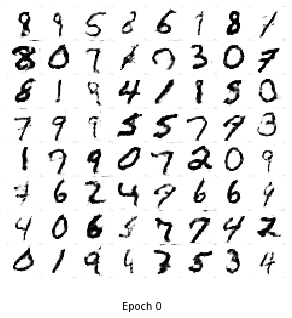

In [27]:
plot_result(generator, fixed_noise, -1, show=True, save=True)